In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.datasets import load_digits
from IPython.display import display
import matplotlib.pyplot as plt
np.random.seed(42)

In [2]:
digits = load_digits(return_X_y=True)
digits_x = digits[0]
digits_y = digits[1]
digits_df = pd.DataFrame(data=digits_x, columns = [f"pixel {i}" for i in range(digits_x.shape[1])])
digits_df['label'] = digits_y

credit_approval = pd.read_csv('credit_approval.csv')
parkinsons = pd.read_csv('parkinsons.csv')
parkinsons.rename(columns={'Diagnosis':'label'},inplace=True)
rice = pd.read_csv('rice.csv')
rice['label'] = rice['label'].map({'Cammeo': 1, 'Osmancik':0})

In [3]:
def construct_folds(dataset, k):
    #divide the dataset into folds with equal length
    shuffled_dataset=shuffle(dataset)
    fold_length, remainder  = divmod(len(dataset), k)

    #calculate the class distribution as a percentage
    label_1_percentage = len(dataset[dataset['label']==1])/len(dataset)
    label_0_percentage = len(dataset[dataset['label']==0])/len(dataset)


    label_1_instances = shuffled_dataset[shuffled_dataset['label']==1]
    label_0_instances = shuffled_dataset[shuffled_dataset['label']==0]

    #get the length that each fold will end up being
    fold_lengths = []
    for i in range(k):
        fold_lengths.append(fold_length)
    i=0
    while remainder>0:
        fold_lengths[i]+=1
        if i == len(fold_lengths)-1:
            i=0
        else:
            i+=1
        remainder -= 1
    
    fold_frames = [pd.DataFrame(index=range(fold_length)) for fold_length in fold_lengths]
    
    j=0
    for fold_length in fold_lengths:
        fold_0_amount = int(fold_length * label_0_percentage)
        fold_1_amount = int(fold_length * label_1_percentage)
        fold_0_rows = label_0_instances.sample(fold_0_amount, replace=False)
        fold_1_rows = label_1_instances.sample(fold_1_amount, replace=False)
        fold_frames[j]=pd.concat([fold_0_rows, fold_1_rows])
        label_1_instances = label_1_instances.drop(fold_1_rows.index).reset_index(drop=True)
        label_0_instances = label_0_instances.drop(fold_0_rows.index).reset_index(drop=True)
        j+=1
    return fold_frames

In [81]:
def normalize_2(dataset, norm_columns):
    dataset_1 = dataset.copy()
    for col in norm_columns:
        min = dataset_1[col].min()
        max = dataset_1[col].max()
        values = dataset_1[col]
        normalized = (values - min)/(max-min)
        dataset_1[col]=normalized
    return dataset_1




def normalize(train_set, test_set,norm_columns):
    train_norm = train_set.copy()
    test_norm  = test_set.copy()
    for col in norm_columns:
        min = train_norm[col].min()
        max = train_norm[col].max()
        values = train_norm[col]
        normalized = (values - min)/(max-min)
        train_norm[col]=normalized
        test_norm[col]= (test_norm[col]-min)/(max-min)
    return train_norm, test_norm



def normalize_3(train_set, test_set,norm_columns):
    train_norm = train_set.copy()
    test_norm  = test_set.copy()
    for col in norm_columns:
        mean = np.mean(train_norm[col])
        std = np.std(train_norm[col])
        values = train_norm[col]
        normalized = (values - mean)/std
        train_norm[col]=normalized
        test_norm[col]= (test_norm[col]-mean)/(std)
    return train_norm, test_norm
def euclidian_distance(row1,row2):
    return np.sqrt((np.sum((row2-row1)**2, axis=1)).astype(np.float64))


def find_most_common_label(sorted_dataframe, k_value):
    count_0=0
    count_1=0
    sub_df = sorted_dataframe.head(k_value)
    #display(sub_df)
    for i, row in sub_df.iterrows():
        if row['label'] == 0.0:
            count_0+=1
        else:
            count_1+=1
    if count_1>count_0:
        return 1
    else:
        return 0
    
def knn(train_set, test_set, k_value, cols_before_label):
    tp=0
    fp=0
    fn=0
    tn=0
    for index, row in test_set.iterrows():
        train_set['distance'] = euclidian_distance(row.iloc[:cols_before_label].values, train_set.iloc[:,:cols_before_label].values)
        train_sorted_by_distance = train_set.sort_values(by='distance')
        test_set.at[index, 'prediction'] = find_most_common_label(train_sorted_by_distance, k_value)
    for _, row in test_set.iterrows(): 
        if row['prediction'] == 1 and row['label'] == 1:
            tp+=1
        elif row['prediction'] == 1 and row['label'] == 0:
            fp+=1
        elif row['prediction'] == 0 and row['label'] == 1:
            fn+=1
        else:
            tn+=1
    accuracy = (tp+tn)/(tp+fp+tn+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = (2*precision*recall)/(precision+recall)
    return accuracy, f1_score

def train_knn(dataset, cols_before_label, k_values, norm_columns):
    dataset_1 = dataset.copy()
    dataset_1 = dataset.reset_index(drop=True)

    
    accuracy_f1_pair = []
    for k in k_values:
        folds = construct_folds(dataset_1, 10)
        accuracy_arr = []
        f1_arr = []
        for i in range(10):
            test_fold = folds.pop(0)
            train_set = pd.concat(folds)
            train_set['distance']=0
            test_fold['prediction']=None
            train_norm, test_norm = normalize(train_set, test_fold, norm_columns)
            accuracy,f1= knn(train_norm, test_norm, k, cols_before_label)
            accuracy_arr.append(accuracy)
            f1_arr.append(f1)
            train_set = train_set.drop(columns=['distance'])
            test_fold = test_fold.drop(columns=['prediction'])
            folds.append(test_fold)
        accuracy_f1_pair.append({np.mean(accuracy_arr):np.mean(f1_arr)})
    return accuracy_f1_pair
            

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical = ['attr1_cat','attr4_cat', 'attr5_cat','attr6_cat','attr7_cat','attr9_cat','attr10_cat','attr11_cat','attr12_cat','attr13_cat']

transformer = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(sparse_output=False), categorical)],
    remainder='passthrough'
)
credit_transformer = pd.DataFrame(transformer.fit_transform(credit_approval), columns=transformer.get_feature_names_out())

credit_transformer.columns = credit_transformer.columns.str.strip()
credit_transformer.rename(columns={'remainder__label':'label'},inplace=True)

In [ ]:
#parkinsons_norm = normalize_2(parkinsons,parkinsons.columns[:-1])
accuracy_f1_pair = train_knn(rice, 7, [1,2,3,4,5,6,7,8,9,10,11,12,13], rice.columns[:-1])
accuracy_f1_pair

PARKINSONS

In [17]:
from sklearn.model_selection import train_test_split


df = parkinsons.copy()
for col in df:
    min = df[col].min()
    max = df[col].max()
    values = df[col]
    normalized_column = (values - min) / (max-min)
    df[col] = normalized_column
normalized_df = df
#display(normalized_df.head())




def euclidian_distance(row1,row2):
    # print(row1)
    # print(row2.shape)
    return np.sqrt(np.sum(((row2-row1)**2), axis=1))


def find_most_common_label(sorted_dataframe, k_value):
    count_0=0
    count_1=0
    sub_df = sorted_dataframe.head(k_value)
    #display(sub_df)
    for i, row in sub_df.iterrows():
        if row['label'] == 0.0:
            count_0+=1
        else:
            count_1+=1
    if count_1>count_0:
        return 1
    else:
        return 0




k_values=[3,5,7,9,11,13]

f1_score_testing = []
accuracy_list_testing_2 = []
folds = construct_folds(normalized_df,10)
#for each k value 
for val in k_values:
    f1_percentage_testing = []
    accuracy_percentages_testing = []
    #run the knn algorithm 20 times for each value of k 
    for i in range(10):
        tp=0
        tn=0
        fp=0
        fn=0
        #shuffle and split the data, get the test set and training set
        # train_combined, test_combined = shuffle_and_split(normalized_df)
        test_combined = folds.pop(0)
        train_combined = pd.concat(folds)
       
            
        for index2, row2 in test_combined.iterrows():
            distances = euclidian_distance(row2.iloc[:22], train_combined.iloc[:,:22])
            train_combined_copy = train_combined.copy()
            train_combined_copy['distance'] = distances

            train_sorted_by_distance = train_combined_copy.sort_values(by='distance')
            #display(train_sorted_by_distance.head(val))
            prediction = find_most_common_label(train_sorted_by_distance, val)
            row2['prediction'] = prediction
            if row2['prediction'] == row2['label']==1:
                tp+=1
            elif row2['prediction'] == row2['label']==0:
                tn+=1
            elif row2['prediction'] == 0 and row2['label']==1:
                fn+=1
            elif row2['prediction'] == 1 and row2['label']==0:
                fp+=1
            
        #display(train_combined)
        #after all predictions are made and correct predictions are calcualted, put the accuracy percentage into an array
        accuracy = (tp+tn)/(tp+fp+tn+fn)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1_score = (2*precision*recall)/(precision+recall)
        accuracy_percentages_testing.append(accuracy)
        f1_percentage_testing.append(f1_score)
        #print(correct_predictions/len(train_combined))
        #print(correct_predictions)
        
        
        folds.append(test_combined)
        
    accuracy_list_testing_2.append(np.mean(accuracy_percentages_testing))
    f1_score_testing.append(np.mean(f1_percentage_testing))
print(accuracy_list_testing_2)
print(f1_score_testing)


[np.float64(0.935672514619883), np.float64(0.914327485380117), np.float64(0.9084795321637428), np.float64(0.8707602339181287), np.float64(0.8760233918128654), np.float64(0.8494152046783625)]
[np.float64(0.9592716775252926), np.float64(0.947176242268011), np.float64(0.9442072540918481), np.float64(0.9219807060755336), np.float64(0.9261484983314794), np.float64(0.9125155128792339)]


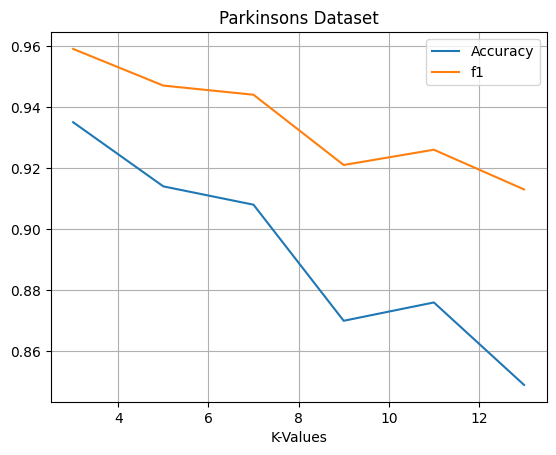

In [22]:

plt.plot([3,5,7,9,11,13], [0.935,0.914,0.908,0.870,0.876,0.849], label="Accuracy")
plt.plot([3,5,7,9,11,13],[0.959,0.947,0.944,0.921,0.926,0.913], label="f1")
plt.grid(True)
plt.xlabel('K-Values')
plt.title("Parkinsons Dataset")
plt.legend()
plt.show()


RICE

In [18]:
from sklearn.model_selection import train_test_split


df = rice.copy()
for col in df:
    min = df[col].min()
    max = df[col].max()
    values = df[col]
    normalized_column = (values - min) / (max-min)
    df[col] = normalized_column
normalized_df = df
#display(normalized_df.head())




def euclidian_distance(row1,row2):
    # print(row1)
    # print(row2.shape)
    return np.sqrt(np.sum(((row2-row1)**2), axis=1))


def find_most_common_label(sorted_dataframe, k_value):
    count_0=0
    count_1=0
    sub_df = sorted_dataframe.head(k_value)
    #display(sub_df)
    for i, row in sub_df.iterrows():
        if row['label'] == 0.0:
            count_0+=1
        else:
            count_1+=1
    if count_1>count_0:
        return 1
    else:
        return 0




k_values=[1,3,5,7,9,11,13]

f1_score_testing = []
accuracy_list_testing_2 = []
folds = construct_folds(normalized_df,10)
#for each k value 
for val in k_values:
    f1_percentage_testing = []
    accuracy_percentages_testing = []
    #run the knn algorithm 20 times for each value of k 
    for i in range(10):
        tp=0
        tn=0
        fp=0
        fn=0
        #shuffle and split the data, get the test set and training set
        # train_combined, test_combined = shuffle_and_split(normalized_df)
        test_combined = folds.pop(0)
        train_combined = pd.concat(folds)
       
            
        for index2, row2 in test_combined.iterrows():
            distances = euclidian_distance(row2.iloc[:7], train_combined.iloc[:,:7])
            train_combined_copy = train_combined.copy()
            train_combined_copy['distance'] = distances

            train_sorted_by_distance = train_combined_copy.sort_values(by='distance')
            #display(train_sorted_by_distance.head(val))
            prediction = find_most_common_label(train_sorted_by_distance, val)
            row2['prediction'] = prediction
            if row2['prediction'] == row2['label']==1:
                tp+=1
            elif row2['prediction'] == row2['label']==0:
                tn+=1
            elif row2['prediction'] == 0 and row2['label']==1:
                fn+=1
            elif row2['prediction'] == 1 and row2['label']==0:
                fp+=1
            
        #display(train_combined)
        #after all predictions are made and correct predictions are calcualted, put the accuracy percentage into an array
        accuracy = (tp+tn)/(tp+fp+tn+fn)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1_score = (2*precision*recall)/(precision+recall)
        accuracy_percentages_testing.append(accuracy)
        f1_percentage_testing.append(f1_score)
        #print(correct_predictions/len(train_combined))
        #print(correct_predictions)
        
        
        folds.append(test_combined)
        
    accuracy_list_testing_2.append(np.mean(accuracy_percentages_testing))
    f1_score_testing.append(np.mean(f1_percentage_testing))
print(accuracy_list_testing_2)
print(f1_score_testing)


[np.float64(0.8871391076115485), np.float64(0.9102362204724409), np.float64(0.9183727034120734), np.float64(0.9217847769028872), np.float64(0.9238845144356954), np.float64(0.9241469816272966), np.float64(0.9244094488188976)]
[np.float64(0.8683010656514174), np.float64(0.8943876275799983), np.float64(0.9041138602528156), np.float64(0.9081197020221634), np.float64(0.9107149094153708), np.float64(0.9112019672274689), np.float64(0.9110825828755541)]


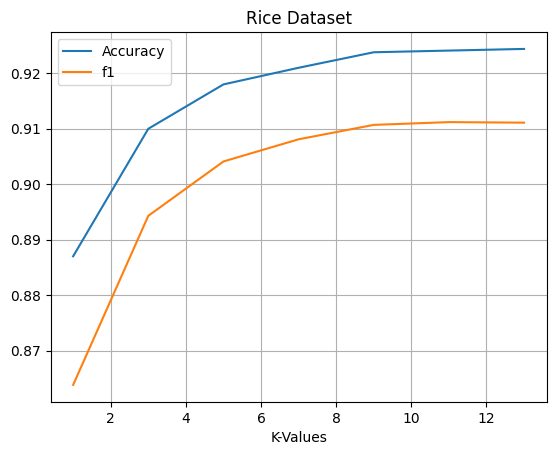

In [24]:
plt.plot([1,3,5,7,9,11,13], [0.887, .910, .918, .921, .9238, .9241, .9244 ], label="Accuracy")
plt.plot([1,3,5,7,9,11,13],[.8638, .8943, .9041, .9081, .9107, .9112, .9111], label="f1")
plt.grid(True)
plt.xlabel('K-Values')
plt.title("Rice Dataset")
plt.legend()
plt.show()

CREDIT APPROVAL

In [19]:
from sklearn.model_selection import train_test_split


df = credit_transformer.copy()
for col in df:
    min = df[col].min()
    max = df[col].max()
    values = df[col]
    normalized_column = (values - min) / (max-min)
    df[col] = normalized_column
normalized_df = df
#display(normalized_df.head())




def euclidian_distance(row1,row2):
    # print(row1)
    # print(row2.shape)
    return np.sqrt(np.sum(((row2-row1)**2), axis=1))


def find_most_common_label(sorted_dataframe, k_value):
    count_0=0
    count_1=0
    sub_df = sorted_dataframe.head(k_value)
    #display(sub_df)
    for i, row in sub_df.iterrows():
        if row['label'] == 0.0:
            count_0+=1
        else:
            count_1+=1
    if count_1>count_0:
        return 1
    else:
        return 0




k_values=[1,3,5,7,9,11,13]

f1_score_testing = []
accuracy_list_testing_2 = []
folds = construct_folds(normalized_df,10)
#for each k value 
for val in k_values:
    f1_percentage_testing = []
    accuracy_percentages_testing = []
    #run the knn algorithm 20 times for each value of k 
    for i in range(10):
        tp=0
        tn=0
        fp=0
        fn=0
        #shuffle and split the data, get the test set and training set
        # train_combined, test_combined = shuffle_and_split(normalized_df)
        test_combined = folds.pop(0)
        train_combined = pd.concat(folds)
       
            
        for index2, row2 in test_combined.iterrows():
            distances = euclidian_distance(row2.iloc[:68], train_combined.iloc[:,:68])
            train_combined_copy = train_combined.copy()
            train_combined_copy['distance'] = distances

            train_sorted_by_distance = train_combined_copy.sort_values(by='distance')
            #display(train_sorted_by_distance.head(val))
            prediction = find_most_common_label(train_sorted_by_distance, val)
            row2['prediction'] = prediction
            if row2['prediction'] == row2['label']==1:
                tp+=1
            elif row2['prediction'] == row2['label']==0:
                tn+=1
            elif row2['prediction'] == 0 and row2['label']==1:
                fn+=1
            elif row2['prediction'] == 1 and row2['label']==0:
                fp+=1
            
        #display(train_combined)
        #after all predictions are made and correct predictions are calcualted, put the accuracy percentage into an array
        accuracy = (tp+tn)/(tp+fp+tn+fn)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1_score = (2*precision*recall)/(precision+recall)
        accuracy_percentages_testing.append(accuracy)
        f1_percentage_testing.append(f1_score)
        #print(correct_predictions/len(train_combined))
        #print(correct_predictions)
        
        
        folds.append(test_combined)
        
    accuracy_list_testing_2.append(np.mean(accuracy_percentages_testing))
    f1_score_testing.append(np.mean(f1_percentage_testing))
print(accuracy_list_testing_2)
print(f1_score_testing)


[np.float64(0.8133653846153847), np.float64(0.8538461538461538), np.float64(0.8678125), np.float64(0.8677884615384615), np.float64(0.8724999999999999), np.float64(0.8616105769230769), np.float64(0.8615865384615384)]
[np.float64(0.7847294252464407), np.float64(0.8354752551354491), np.float64(0.8522528341351606), np.float64(0.8522123919505391), np.float64(0.8569843027416134), np.float64(0.8420729050850569), np.float64(0.8412063193271531)]


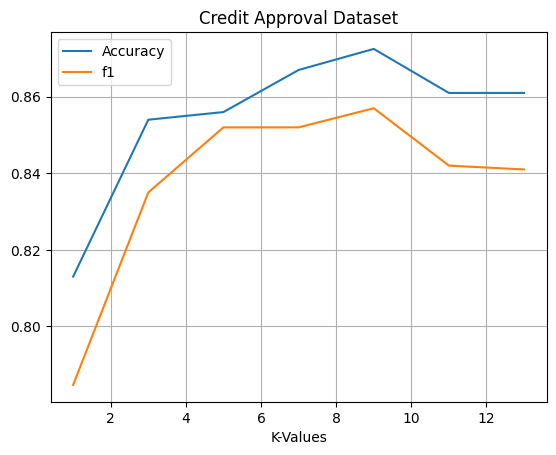

In [25]:
plt.plot([1,3,5,7,9,11,13], [0.813, .854, .856, .867, .8725, .861, .861 ], label="Accuracy")
plt.plot([1,3,5,7,9,11,13],[.7847, .835,.852, .852, .857, .842, .841], label="f1")
plt.grid(True)
plt.xlabel('K-Values')
plt.title("Credit Approval Dataset")
plt.legend()
plt.show()